# Group Project: Composite Urban Heat Risk Index via PCA

## Data Resources and Usage

The data used in this project comes from two main resources: 

Source (1): The Environment Health Data Portal from nyc.gov (https://a816-dohbesp.nyc.gov/IndicatorPublic/)

Source (2): The NYC Opendata Portal (https://opendata.cityofnewyork.us/)

The dataset we used can be categorized into four main aspects: the heat vulnerability index (HVI) from source (1), the household air conditioner percentage from source (1), the cooling feature data from source (2) that contains the census data from the "Cool It! NYC 2020" project on spray showers, cooling fountains, and other cooling sites; our research also requires the GIS data that help us plot the distribution by NYC's NTA2020 (Neighborhood Tabulation Area) & PUMA2010 from source (2)

## (1) Import packages

In [14]:
# === Step 0: Shapely patch for multipart‐geometry errors ===
import shapely.geometry.base
if hasattr(shapely.geometry.base.BaseMultipartGeometry, "__array_interface__"):
    del shapely.geometry.base.BaseMultipartGeometry.__array_interface__

# === Step 1: Imports ===
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## (2) Prepare the NTA layer, PUMA layer, and overlap layers form AC data

In [15]:
# === 2) Load & prepare NTA layer ===
gdf_nta = gpd.read_file("nynta2020.shp").to_crs("EPSG:4326")
# derive boroughs by dissolving on BoroName
gdf_boro = gdf_nta.dissolve(by="BoroName")[["geometry"]].reset_index()

# === 3) Load & prepare PUMA layer (for AC%) ===
gdf_puma = gpd.read_file("puma2010.shp")
gdf_puma = gdf_puma.set_crs("EPSG:2263", allow_override=True).to_crs("EPSG:4326")

# compute centroids in projected CRS for accuracy
nta_cent = gdf_nta.to_crs("EPSG:3857").copy()
nta_cent["geometry"] = nta_cent.geometry.centroid
nta_cent = nta_cent.to_crs("EPSG:4326")[["NTAName","geometry"]]

nta_puma = (
    gpd.sjoin(nta_cent, gdf_puma[["PUMA","geometry"]],
              how="left", predicate="within")
    .drop_duplicates("NTAName")[["NTAName","PUMA"]]
)
nta_puma["PUMA"] = nta_puma["PUMA"].astype(str)


# (3) Load and count the cooling features per NTA

The cooling feature consists of spray showers, cooling fountains, and other cooling sites, each of these cooling features has its latitude and longitude, we use the GeoDataFrame to bound the 

PCA‐derived weights (for site_count_neg, HVI, AC_pct_neg): {'site_count_neg': np.float64(0.367), 'HVI': np.float64(0.206), 'AC_pct_neg': np.float64(0.427)}


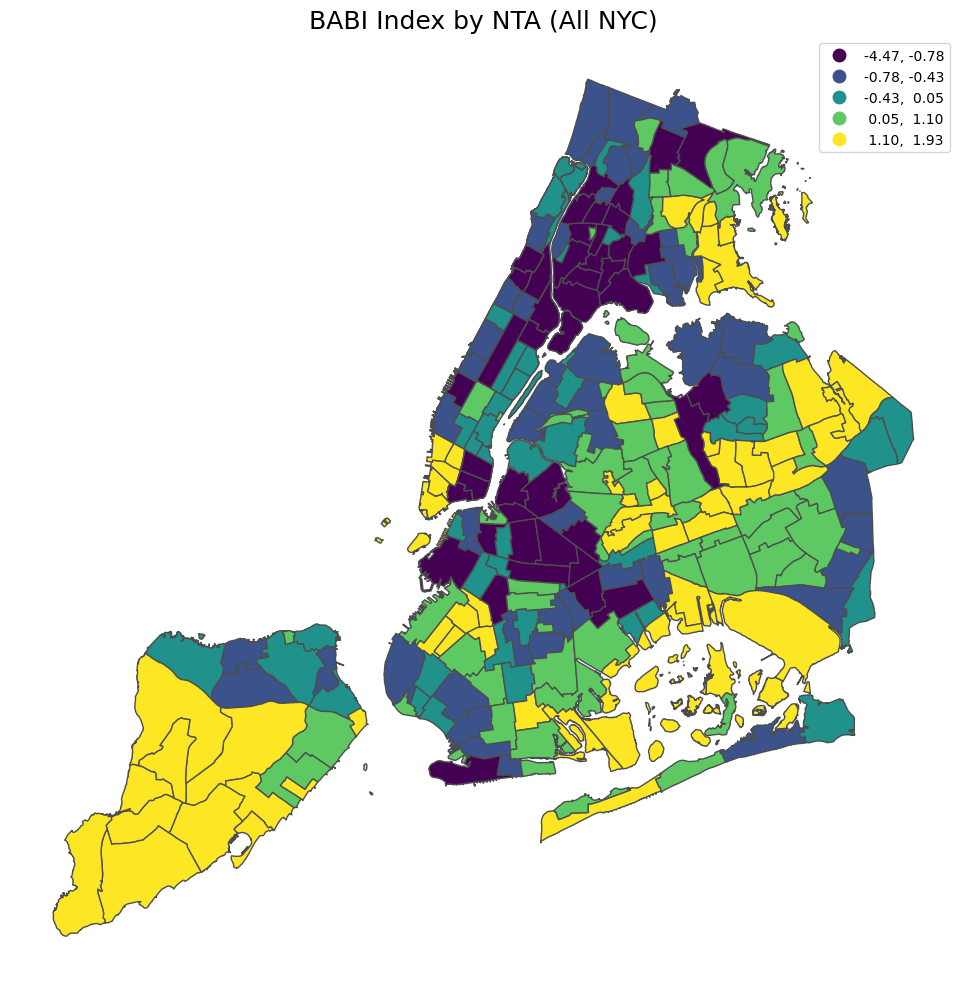

In [16]:
# === 4) Load & count cooling points per NTA ===
df_cool = pd.read_csv("nyc.csv")
df_cool = df_cool[df_cool.Status=="Activated"].dropna(subset=["x","y"]).copy()
gdf_cool = gpd.GeoDataFrame(df_cool,
    geometry=gpd.points_from_xy(df_cool.x, df_cool.y),
    crs="EPSG:4326"
)

borough_map = {"B":"Brooklyn","X":"Bronx","M":"Manhattan","m":"Manhattan","Q":"Queens","R":"Richmond"}
layers = {
    "Spray Showers":      "Cool_It__NYC_2020_-_Spray_Showers_20250618.csv",
    "Drinking Fountains": "Cool_It__NYC_2020_-_Drinking_Fountains_20250618.csv"
}
gdfs = {}
for label, fp in layers.items():
    df = pd.read_csv(fp)
    key = "Status" if "Status" in df.columns else "DF Activated"
    df = df[df[key]=="Activated"].dropna(subset=["x","y","Borough"]).copy()
    df["Borough"] = df["Borough"].map(borough_map)
    gdfs[label] = (
        gpd.GeoDataFrame(df,
            geometry=gpd.points_from_xy(df.x, df.y),
            crs="EPSG:2263"
        )
        .to_crs("EPSG:4326")
    )

all_pts = pd.concat([gdfs["Drinking Fountains"], gdfs["Spray Showers"], gdf_cool], ignore_index=True)
all_pts = gpd.GeoDataFrame(all_pts, geometry=all_pts.geometry, crs="EPSG:4326")
pt_join = gpd.sjoin(all_pts, gdf_nta[["NTAName","geometry"]], how="left", predicate="within")
site_counts = pt_join.groupby("NTAName").size().reset_index(name="site_count")

# === 5) Load HVI & AC% data ===
# 5a) HVI by NTA
hvi_df = pd.read_csv("NYC EH Data Portal - Heat vulnerability index (NTA) (full table) (2).csv")
hvi = (hvi_df
       .rename(columns={"Geography":"NTAName","Score out of 5":"HVI"})
       [["NTAName","HVI"]]
)

# 5b) AC% by PUMA – **filter to 2017 only**
ac_df = pd.read_csv("NYC EH Data Portal - Household air conditioning (full table) (2).csv")
# inspect your year column name:
# print(ac_df.columns); print(ac_df["Year"].unique(), ac_df["Time Period"].unique())
if "Year" in ac_df.columns:
    ac_df = ac_df[ac_df["Year"] == 2017].copy()
elif "Time Period" in ac_df.columns:
    ac_df = ac_df[ac_df["Time Period"].str.contains("2017")].copy()

ac = (ac_df
      .rename(columns={"GeoID":"PUMA","Percent (with AC)":"AC_pct"})
      [["PUMA","AC_pct"]]
)
ac["AC_pct"] = ac["AC_pct"].str.extract(r"([\d\.]+)").astype(float)
ac["PUMA"]   = ac["PUMA"].astype(str)

# === 6) Merge into master BABI table ===
babi = (
    pd.DataFrame({"NTAName":gdf_nta.NTAName})
      .merge(site_counts, on="NTAName", how="left")
      .merge(hvi,         on="NTAName", how="left")
      .merge(nta_puma,    on="NTAName", how="left")
      .merge(ac,          on="PUMA",    how="left")
)
babi[["site_count","HVI","AC_pct"]] = babi[["site_count","HVI","AC_pct"]].fillna(0)

# === 7) Compute BABI via PCA, inverting site_count & AC_pct ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a matrix where protective factors are negated:
Xmat = pd.DataFrame({
    "site_count_neg": -babi["site_count"],  # more sites → more negative → lower BABI
    "HVI":            babi["HVI"],          # higher HVI → higher BABI
    "AC_pct_neg":     -babi["AC_pct"]        # more AC → more negative → lower BABI
})

# Standardize and run PCA on these three columns
X = StandardScaler().fit_transform(Xmat)
pca = PCA(n_components=1)
babi["BABI"] = pca.fit_transform(X).flatten()

# Extract normalized absolute loadings for interpretation
load = pca.components_[0]
weights = abs(load) / abs(load).sum()
print("PCA‐derived weights (for site_count_neg, HVI, AC_pct_neg):",
      dict(zip(Xmat.columns, weights.round(3))))


# === 8) Merge BABI back onto gdf_nta ===
gdf_nta = gdf_nta.merge(babi[["NTAName","BABI"]], on="NTAName")

# === 9) Plot city-wide choropleth ===
fig, ax = plt.subplots(figsize=(10,10))
gdf_nta.plot(column="BABI", cmap="viridis", scheme="quantiles",
             legend=True, ax=ax, edgecolor="0.3")
ax.set_title("BABI Index by NTA (All NYC)", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("babi_nyc_choropleth.png", dpi=300)
plt.show()



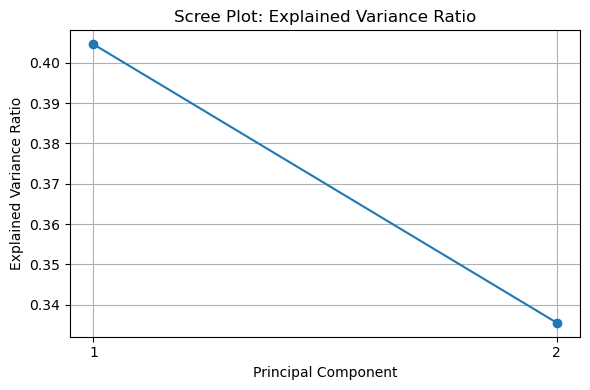

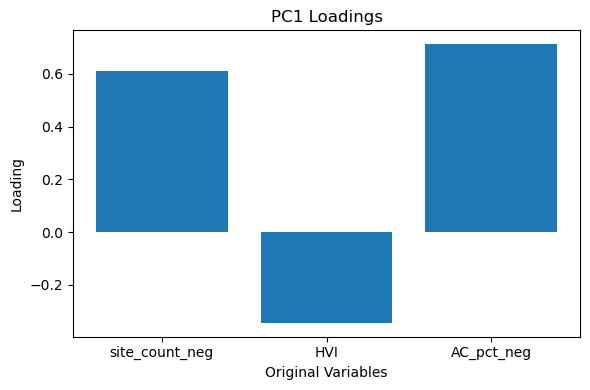

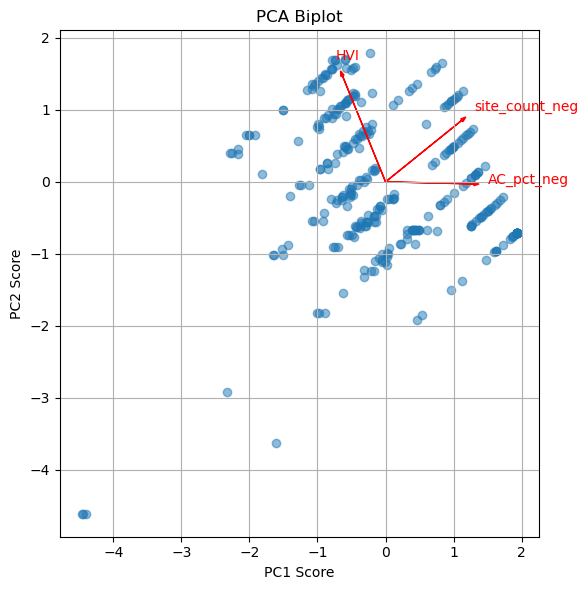

In [19]:
# === PCA Visualization Cell ===

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 0) Make sure you have re-run the cells that build `babi` and `gdf_nta` before executing this.

# 1) Reconstruct the protective‐factors matrix
Xmat = pd.DataFrame({
    "site_count_neg": -babi["site_count"],   # more cooling sites → lower vulnerability
    "HVI":            babi["HVI"],           # higher HVI    → higher vulnerability
    "AC_pct_neg":     -babi["AC_pct"]         # more AC       → lower vulnerability
})

# 2) Standardize
X_std = StandardScaler().fit_transform(Xmat)

# 3) Fit PCA (keep first two components for plotting)
pca = PCA(n_components=2)
scores = pca.fit_transform(X_std)        # shape (n_samples, 2)
loadings = pca.components_               # shape (2, 3)

# 4) Scree plot of explained variance ratio
plt.figure(figsize=(6,4))
plt.plot(
    [1, 2],
    pca.explained_variance_ratio_,
    marker="o", linestyle="-"
)
plt.title("Scree Plot: Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks([1, 2])
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Bar chart of PC1 loadings
plt.figure(figsize=(6,4))
plt.bar(Xmat.columns, loadings[0])
plt.title("PC1 Loadings")
plt.xlabel("Original Variables")
plt.ylabel("Loading")
plt.tight_layout()
plt.show()

# 6) Biplot (PC1 vs PC2 with variable vectors)
plt.figure(figsize=(6,6))
plt.scatter(scores[:,0], scores[:,1], alpha=0.5)
for i, var in enumerate(Xmat.columns):
    plt.arrow(
        0, 0,
        loadings[0, i] * max(scores[:,0]),
        loadings[1, i] * max(scores[:,1]),
        head_width=0.05, length_includes_head=True, color="red"
    )
    plt.text(
        loadings[0, i] * max(scores[:,0]) * 1.1,
        loadings[1, i] * max(scores[:,1]) * 1.1,
        var,
        color="red"
    )
plt.title("PCA Biplot")
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")
plt.grid(True)
plt.tight_layout()
plt.show()
